# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

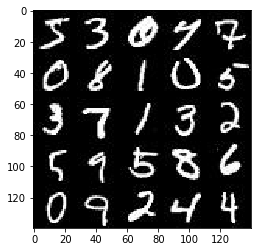

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

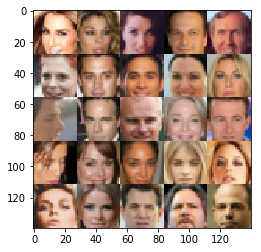

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input_img')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return real_input_img, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    stddev = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        # 14x14x32
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * batch2, batch2)
        
        # 7x7x128
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * batch3, batch3)
        
        # 4x4x256
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    stddev = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # 7x7x256
        fc1 = tf.layers.dense(z, 4 * 4 * 512)
        fc1 = tf.reshape(fc1, (-1, 4, 4, 512))
        batch1 = tf.layers.batch_normalization(fc1, training=is_train)
        relu1 = tf.maximum(alpha * batch1, batch1)
        
        # 4x4x512
        conv2 = tf.layers.conv2d_transpose(relu1, 128, 4, strides=1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha * batch2, batch2)
        
        # 8x8x128
        conv3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha * batch3, batch3)
        
        # 16x16x64
        conv4 = tf.layers.conv2d_transpose(relu3, 32, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch4 = tf.layers.batch_normalization(conv4, training=is_train)
        relu4 = tf.maximum(alpha * batch4, batch4)
        
        # 32x32x32
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                          "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6965... Generator Loss: 5.4028
Epoch 1/2... Discriminator Loss: 5.7478... Generator Loss: 0.0502
Epoch 1/2... Discriminator Loss: 3.6812... Generator Loss: 0.5782
Epoch 1/2... Discriminator Loss: 2.8193... Generator Loss: 10.8578
Epoch 1/2... Discriminator Loss: 3.6223... Generator Loss: 0.5927
Epoch 1/2... Discriminator Loss: 1.9361... Generator Loss: 2.1785
Epoch 1/2... Discriminator Loss: 2.9155... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 2.2789... Generator Loss: 1.9016
Epoch 1/2... Discriminator Loss: 2.4677... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.9809... Generator Loss: 0.8050


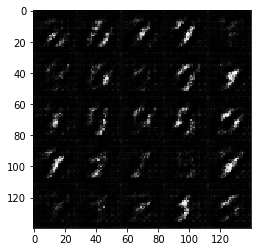

Epoch 1/2... Discriminator Loss: 1.5168... Generator Loss: 1.4652
Epoch 1/2... Discriminator Loss: 1.6928... Generator Loss: 2.0330
Epoch 1/2... Discriminator Loss: 2.8490... Generator Loss: 0.2841
Epoch 1/2... Discriminator Loss: 2.3636... Generator Loss: 1.1906
Epoch 1/2... Discriminator Loss: 3.3050... Generator Loss: 0.1083
Epoch 1/2... Discriminator Loss: 1.8732... Generator Loss: 0.6040
Epoch 1/2... Discriminator Loss: 1.8445... Generator Loss: 3.1801
Epoch 1/2... Discriminator Loss: 1.9196... Generator Loss: 1.0503
Epoch 1/2... Discriminator Loss: 2.2369... Generator Loss: 0.4015
Epoch 1/2... Discriminator Loss: 2.1578... Generator Loss: 3.0224


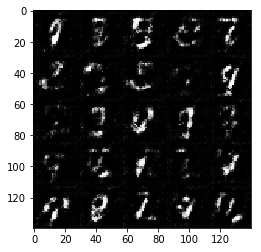

Epoch 1/2... Discriminator Loss: 1.6900... Generator Loss: 2.8752
Epoch 1/2... Discriminator Loss: 1.7246... Generator Loss: 1.3013
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 1.3151
Epoch 1/2... Discriminator Loss: 1.8877... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 2.1438... Generator Loss: 0.3376
Epoch 1/2... Discriminator Loss: 1.7417... Generator Loss: 0.3828
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.5471
Epoch 1/2... Discriminator Loss: 1.9086... Generator Loss: 0.3168
Epoch 1/2... Discriminator Loss: 1.3806... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 2.3708


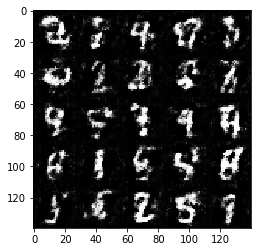

Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 1.8046... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.5359... Generator Loss: 0.5596
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 2.4402
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 1.8450
Epoch 1/2... Discriminator Loss: 1.1161... Generator Loss: 0.9579
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.9287
Epoch 1/2... Discriminator Loss: 1.7223... Generator Loss: 1.8933
Epoch 1/2... Discriminator Loss: 1.9446... Generator Loss: 0.3961


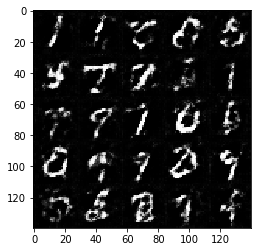

Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 1.0181
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.8508
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 2.1897
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.9093
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 1.4122
Epoch 1/2... Discriminator Loss: 1.4501... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 2.2248
Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 1.9820
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 0.5009


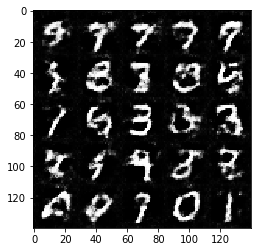

Epoch 1/2... Discriminator Loss: 1.7767... Generator Loss: 0.4278
Epoch 1/2... Discriminator Loss: 1.6159... Generator Loss: 0.4870
Epoch 1/2... Discriminator Loss: 1.1494... Generator Loss: 1.5216
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 2.2492... Generator Loss: 0.2869
Epoch 1/2... Discriminator Loss: 2.0161... Generator Loss: 0.3315
Epoch 1/2... Discriminator Loss: 1.5750... Generator Loss: 0.4737
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 1.5979
Epoch 1/2... Discriminator Loss: 1.9175... Generator Loss: 0.3026


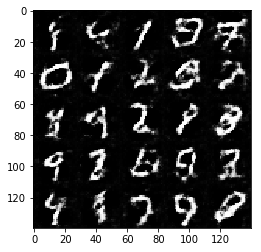

Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 1.4466
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 1.6849... Generator Loss: 0.5098
Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 2.0208
Epoch 1/2... Discriminator Loss: 1.7486... Generator Loss: 2.3276
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 0.5414
Epoch 1/2... Discriminator Loss: 1.6216... Generator Loss: 2.1998
Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 0.4716
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.8564


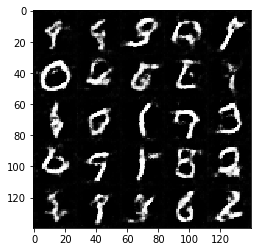

Epoch 1/2... Discriminator Loss: 1.7498... Generator Loss: 0.4242
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 1.0693
Epoch 1/2... Discriminator Loss: 1.5044... Generator Loss: 2.2751
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 1.6226
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.6036... Generator Loss: 1.7863
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.6072


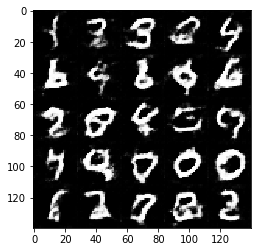

Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 1.2796
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 0.9875
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 1.8358
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 1.6824
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 1.8489


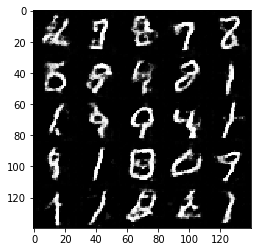

Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 1.1668
Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 2.0693
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.5728
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 1.5481
Epoch 2/2... Discriminator Loss: 1.2889... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 2.1322... Generator Loss: 2.7903
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 1.1869
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 0.6364


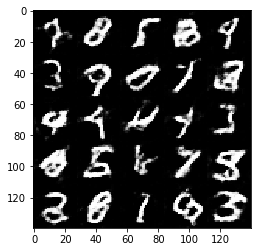

Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.9370
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 1.6568
Epoch 2/2... Discriminator Loss: 1.6452... Generator Loss: 2.1416
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.8430
Epoch 2/2... Discriminator Loss: 1.6404... Generator Loss: 0.4517
Epoch 2/2... Discriminator Loss: 1.5600... Generator Loss: 0.5437
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.6085
Epoch 2/2... Discriminator Loss: 1.1846... Generator Loss: 0.8519
Epoch 2/2... Discriminator Loss: 1.5482... Generator Loss: 0.4718


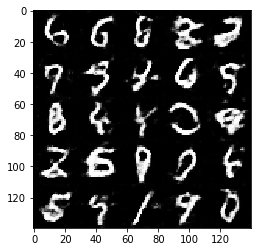

Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 0.9391
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 1.3341
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 1.3508
Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 2.0557
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.8582
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 1.2918
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 1.0299
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 1.7708
Epoch 2/2... Discriminator Loss: 1.5672... Generator Loss: 0.4747


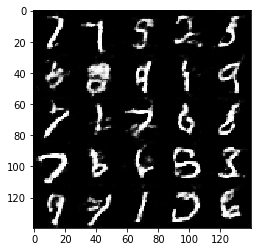

Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.8170
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 2.4049
Epoch 2/2... Discriminator Loss: 1.4411... Generator Loss: 0.7507
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 1.1910... Generator Loss: 2.0118
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 1.8209
Epoch 2/2... Discriminator Loss: 1.4960... Generator Loss: 0.6389
Epoch 2/2... Discriminator Loss: 1.4604... Generator Loss: 0.5243
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 1.5482... Generator Loss: 2.3553


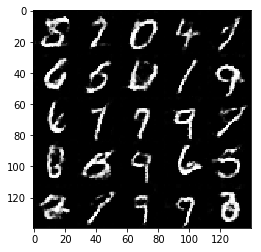

Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 1.6150
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 0.7110
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 1.5782
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.6154
Epoch 2/2... Discriminator Loss: 1.4788... Generator Loss: 0.5283
Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 1.1699
Epoch 2/2... Discriminator Loss: 1.6120... Generator Loss: 0.4467


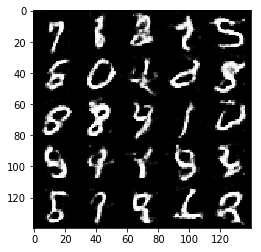

Epoch 2/2... Discriminator Loss: 1.7241... Generator Loss: 0.4716
Epoch 2/2... Discriminator Loss: 1.7087... Generator Loss: 1.7933
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.6402... Generator Loss: 0.4363
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 1.5823
Epoch 2/2... Discriminator Loss: 1.4818... Generator Loss: 0.5415
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 1.2697
Epoch 2/2... Discriminator Loss: 1.6280... Generator Loss: 0.5256
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 1.4885


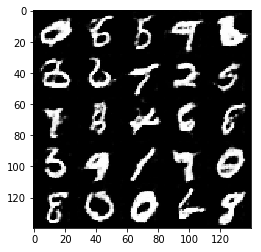

Epoch 2/2... Discriminator Loss: 1.7509... Generator Loss: 0.3395
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.3491
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 1.3386
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.3115
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.5829... Generator Loss: 0.4409
Epoch 2/2... Discriminator Loss: 2.4983... Generator Loss: 0.1845
Epoch 2/2... Discriminator Loss: 1.5210... Generator Loss: 1.7465


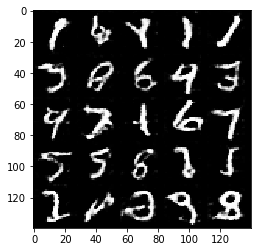

Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 1.1111... Generator Loss: 1.2785
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.9781
Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 1.5756
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 1.0226
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.6901
Epoch 2/2... Discriminator Loss: 1.3208... Generator Loss: 1.8780
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 1.2095... Generator Loss: 1.0576


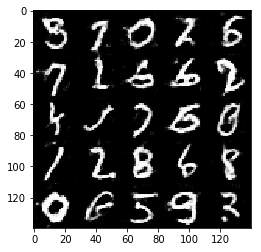

Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 1.2989
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 1.5779... Generator Loss: 0.4938
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 1.5200
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 1.5716
Epoch 2/2... Discriminator Loss: 1.0148... Generator Loss: 0.9841
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 1.4491... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.2030... Generator Loss: 0.7176
Epoch 2/2... Discriminator Loss: 1.7300... Generator Loss: 0.4768


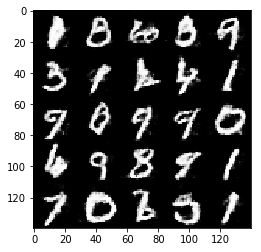

Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 1.1555
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 1.3223
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.8583
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 1.2879
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.7745
Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 1.1165


In [18]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 15.0321... Generator Loss: 0.0000
Epoch 1/1... Discriminator Loss: 2.5814... Generator Loss: 13.9521
Epoch 1/1... Discriminator Loss: 6.9999... Generator Loss: 20.5215
Epoch 1/1... Discriminator Loss: 3.9918... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 12.9335
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 9.9548
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 9.3087
Epoch 1/1... Discriminator Loss: 2.7348... Generator Loss: 0.4510
Epoch 1/1... Discriminator Loss: 2.7872... Generator Loss: 29.2992
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 1.5607


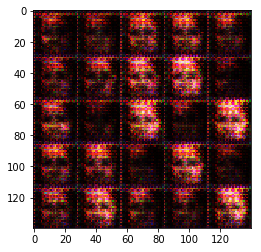

Epoch 1/1... Discriminator Loss: 2.6284... Generator Loss: 1.2603
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 2.3365
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 3.3003
Epoch 1/1... Discriminator Loss: 2.2737... Generator Loss: 0.3277
Epoch 1/1... Discriminator Loss: 4.6724... Generator Loss: 0.1625
Epoch 1/1... Discriminator Loss: 1.8333... Generator Loss: 6.0338
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 6.3528
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 2.0052... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 2.8536... Generator Loss: 6.8828


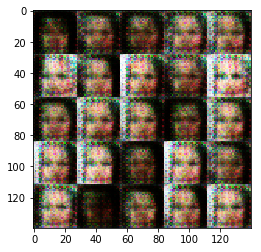

Epoch 1/1... Discriminator Loss: 3.4967... Generator Loss: 0.1796
Epoch 1/1... Discriminator Loss: 2.7075... Generator Loss: 7.9723
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 3.3090
Epoch 1/1... Discriminator Loss: 2.9865... Generator Loss: 0.2568
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 1.7312... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 2.0752
Epoch 1/1... Discriminator Loss: 2.9527... Generator Loss: 0.1783
Epoch 1/1... Discriminator Loss: 1.7546... Generator Loss: 4.5677
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.8963


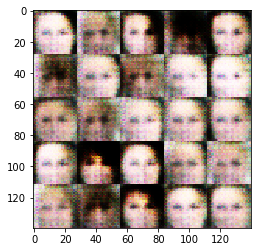

Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 5.3699
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.6780
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 1.7821... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 2.5859
Epoch 1/1... Discriminator Loss: 1.7677... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.4992
Epoch 1/1... Discriminator Loss: 1.6699... Generator Loss: 0.6705


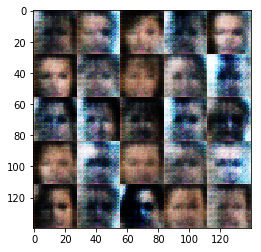

Epoch 1/1... Discriminator Loss: 1.8419... Generator Loss: 2.4401
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 2.3792... Generator Loss: 0.2096
Epoch 1/1... Discriminator Loss: 1.6104... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 2.7387... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.7879... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 2.0007... Generator Loss: 2.7671
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.6995


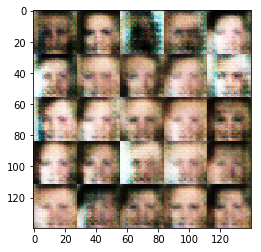

Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 3.0385
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.4199
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 1.8350
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 2.0043
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 2.1273


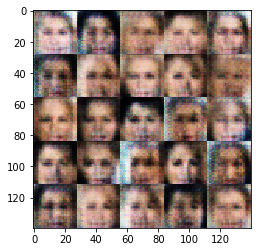

Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.8586... Generator Loss: 3.5327
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.3169
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 1.5524
Epoch 1/1... Discriminator Loss: 1.7321... Generator Loss: 2.9885
Epoch 1/1... Discriminator Loss: 1.8590... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.4084
Epoch 1/1... Discriminator Loss: 1.7428... Generator Loss: 1.2572


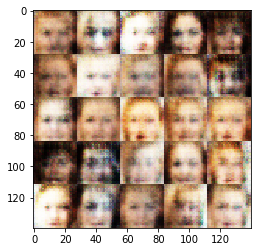

Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.7305... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 1.8984
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 1.9138... Generator Loss: 0.4270
Epoch 1/1... Discriminator Loss: 1.7370... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 1.7795


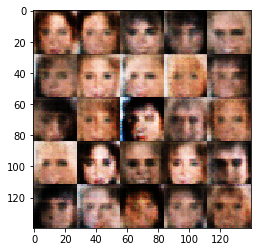

Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.5217
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.7198... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 2.3850
Epoch 1/1... Discriminator Loss: 1.6746... Generator Loss: 1.9323
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8009


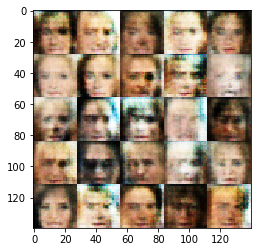

Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 1.6965... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 2.0105... Generator Loss: 0.3333
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 1.5666


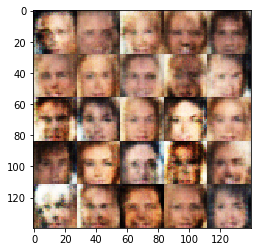

Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 2.1168
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 1.5474
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 2.0174... Generator Loss: 0.3020
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 1.7774
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.7250... Generator Loss: 0.4689


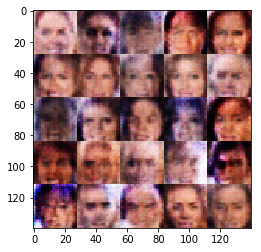

Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.2927
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.9268... Generator Loss: 2.4070
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 1.7046... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 1.3501


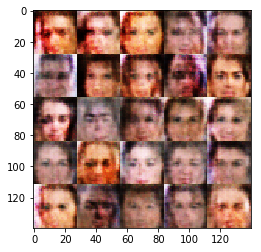

Epoch 1/1... Discriminator Loss: 1.7417... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 1.6680
Epoch 1/1... Discriminator Loss: 1.6509... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6822


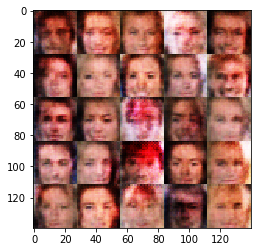

Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 1.5099
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.3409
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 1.3747
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.6318... Generator Loss: 1.8323
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 1.1376


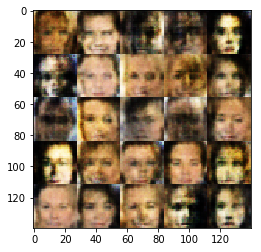

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 2.1900... Generator Loss: 0.2374
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.5832


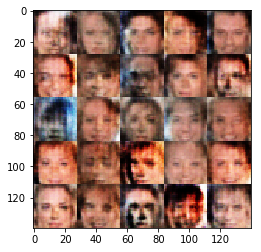

Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.3188
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.7589... Generator Loss: 1.6100
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 1.5353


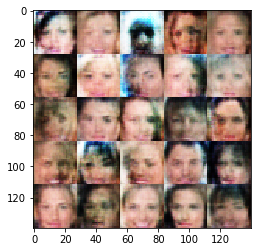

Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.4907
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 1.2302


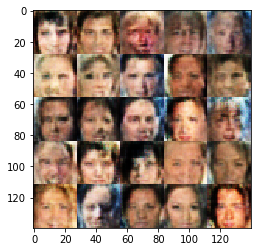

Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 1.1635
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 2.1487
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.7083... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 1.6457
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 1.3303


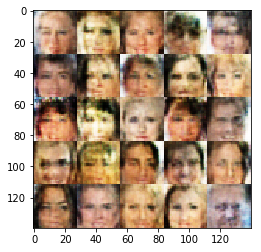

Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.4887
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.4270
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.4208
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.9514


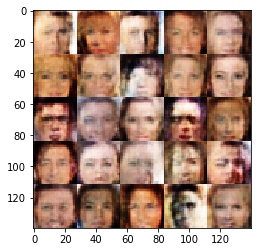

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 1.7068
Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6464


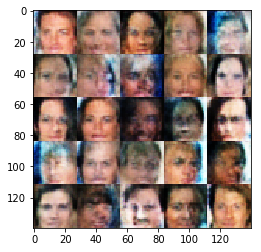

Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.7954... Generator Loss: 0.3451
Epoch 1/1... Discriminator Loss: 1.7158... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.6680... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.9677


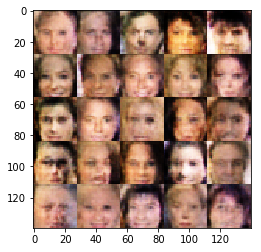

Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.6626... Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.5923


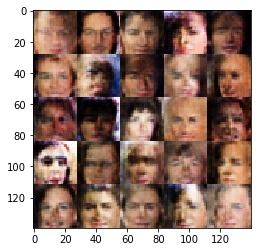

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 1.8491... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 1.3053
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 1.6488


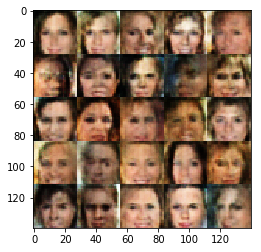

Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7776


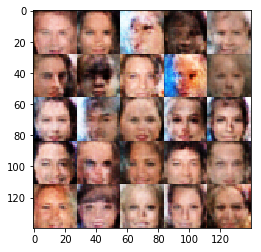

Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 1.7083... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.5727


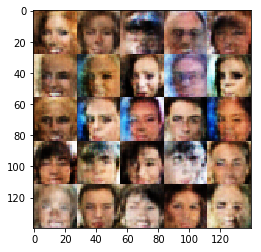

Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.6133... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 1.6617... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.4536


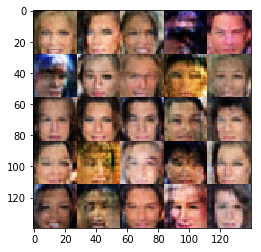

Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.8257... Generator Loss: 1.8373
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.2376


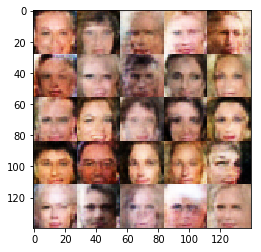

Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.4838
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 1.1393


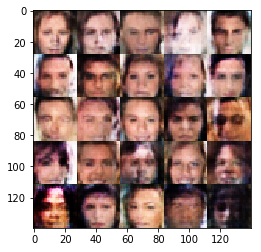

Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.6278... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.1239


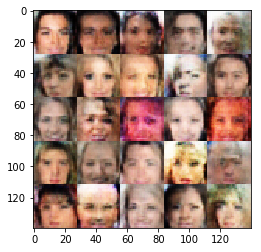

Epoch 1/1... Discriminator Loss: 1.8295... Generator Loss: 1.7845
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 1.4134
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.6558... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 2.1608... Generator Loss: 0.2183


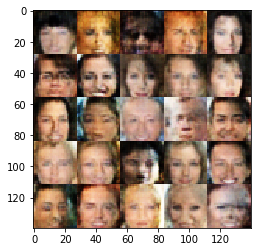

Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.5789


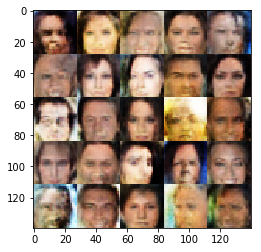

Epoch 1/1... Discriminator Loss: 1.7141... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.4538


In [19]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.